<a href="https://colab.research.google.com/github/Crisitunity-Lab/ARDC-Project/blob/main/Llama2_prod_will.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Llama2 Production

SUMA 12/10/2023

#Instructions

Running code on Google Colab
1.   Create HuggingFace account
2.   Gain access to model: https://huggingface.co/meta-llama/Llama-2-7b-chat-hf
3.   Create folder 'data' in project folder on personal Google Drive
4.   Save data set CrisiLexT26 in folder 'data'
5.   Data sourced from: https://crisislex.org/data-collections.html#CrisisLexT26
6.   Mount Google Drive
7.   Update code with Paths
8.   Set system up as per steps below
9.   Run Experiments
10.  Evaluate

## Setup



*   Only 4kb for the labeled tweet data for each crisis with all the columns so not worth keeping only tweet ID in output csv.
*   Can run the whole thing after changing the Crisis Event below however first couple of times maybe CTRL+8 from experiements the first couple of times to be safe





In [ ]:
# Declare which Crisis Event to run
crisis_event="2013_Queensland_floods"
# Crisis_Event                Status

# 2013_Queensland_floods      RT DOING
# 2013_Bohol_earthquake
# 2013_LA_airport_shootings
# 2013_Typhoon_Yolanda
# 2013_Alberta_floods
# 2013_Spain_train_crash
# 2013_West_Texas_explosion
# 2013_Boston_bombings
# 2013_Australia_bushfire
# 2012_Colorado_wildfires
# 2012_Philipinnes_floods
# 2012_Venezuela_refinery
# 2013_Russia_meteor
# 2012_Guatemala_earthquake
# 2013_Manila_floods
# 2013_NY_train_crash
# 2013_Savar_building_collapse
# 2012_Italy_earthquakes
# 2013_Glasgow_helicopter_crash
# 2013_Lac_Megantic_train_crash
# 2013_Colorado_floods
# 2013_Sardinia_floods
# 2012_Costa_Rica_earthquake
# 2013_Brazil_nightclub_fire
# 2012_Typhoon_Pablo


In [ ]:
# Logging onto HuggingFace
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# Mounting GDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Install Transformer package
!pip install -q transformers einops accelerate langchain bitsandbytes
!pip install sentencepiece


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.0 MB/s eta 0:00:00


In [ ]:
# Import Packages
from langchain import PromptTemplate,  LLMChain
from langchain import HuggingFacePipeline
from transformers import AutoTokenizer
import transformers
import torch
import pandas as pd
import numpy as np
import json
import os
import csv
import time
import re
import matplotlib.pyplot as plt
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import datetime


### Prerequisites

To load our desired model, `meta-llama/Llama-2-7b-chat-hf`, we first need to authenticate ourselves on Hugging Face. This ensures we have the correct permissions to fetch the model.

1. Gain access to the model on Hugging Face: [Link](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf).
2. Use the Hugging Face CLI to login and verify your authentication status.


## Preparing data

In [ ]:
# Read CSV file - only use if you wnat to skip inporting  and concatenating
result_df = pd.read_csv('/content/gdrive/MyDrive/iLab2/result_df_raw_rt.csv')


## Modeling

In [ ]:
# Tokenizer
model = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(model)

pipeline = transformers.pipeline(
    "text-generation", #task
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
    max_length=1000,
    do_sample=True,
    top_k=10,

    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Load model
llm = HuggingFacePipeline(pipeline = pipeline, model_kwargs = {'temperature':0})


In [ ]:
# Prompt Template Formatting
B_INST, E_INST = "[INST]", "[/INST]"
B_SYS, E_SYS = "<>\n", "\n<>\n\n"
DEFAULT_SYSTEM_PROMPT = """\
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information."""

def get_prompt(instruction, new_system_prompt=DEFAULT_SYSTEM_PROMPT ):
    SYSTEM_PROMPT = B_SYS + new_system_prompt + E_SYS
    prompt_template =  B_INST + SYSTEM_PROMPT + instruction + E_INST
    return prompt_template

def parse_text(text):
        wrapped_text = textwrap.fill(text, width=100)
        print(wrapped_text +'\n\n')
        # return assistant_text


In [ ]:
def generate_answer(text, system_prompt, instruction):
  prompt_template = get_prompt(instruction, system_prompt)
  prompt = PromptTemplate(template=prompt_template, input_variables= ['text'])
  llm_chain = LLMChain(prompt=prompt, llm=llm)
  text = llm_chain.run(text)
  return text


## Filter for Crisis Event - CHECK IF VOLUMES CORRECT BEFORE RUNNING LLMS

In [ ]:
# Grab random samples
filtered_df = result_df.query(f'Label == {crisis_event}')
testing_df = result_df.sample(n=10, random_state=42) #TURN OFF TO RUN OVER FULL DATASET
testing_df.columns = testing_df.columns.str.replace(' ', '')
testing_df['TweetText'] = testing_df['TweetText'].astype(str)

# Filter for TweetText string greater than 5 words excluding words starting with "@"" and "http"
testing_df = testing_df[testing_df['TweetText'].str.split().apply(lambda x: sum(1 for word in x if not word.startswith('@') and not word.startswith('http') and not word.startswith('#') )) > 5]
print(testing_df["Label"][0])
len(testing_df.index)



## Experiments - YOU CAN CTRL +F8 to run all the code above

### Crisis Type Label

In [ ]:
%%time
# Crisis Type Labels **v13**
# Running over data v1 [with explination] [remove   Return in max 3 words.]  [return label in quotation] [incl war, natural disasters] 15 best because some in quoteation and some in label format

system_prompt = "You are an advance assistant that excels at classifying whether the text that contains useful information during or after a crisis. A crisis can include bushfires, wildfires, floods, hurricanes, earthquakes, covid-19, pandemic, war, natural disasters etc. Stop after giving one answer. Format answer in JSON. Provide an explanation. "
instruction = "Recognize whether this text is in relation to a crisis but do not tell me. If the text is in relation to a crisis, label in one word what is the name of the crisis. If no crisis exists, then only answer \"[NA]\". Return in max 3 words with explanation. Format in JSON. The text is: {text}"

# Create an empty 'answer' column in testing_df
testing_df['pred_crisis_type_13'] = ''

# Loop over the data
for index, row in testing_df.iterrows():
    TweetText = row['TweetText']
    # Update the 'answer' column in the DataFrame using the output from generate_answer
    testing_df.loc[index, 'pred_crisis_type_13'] = generate_answer(TweetText, system_prompt, instruction)

testing_df.head(100) # Can comment out if you dont want to see sample of results




In [ ]:
# Save to CSV file
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
outFileName= f'/content/gdrive/MyDrive/iLab2/{timestamp}_{crisis_event}.csv'
testing_df.to_csv(outFileName, index=False)

### Crisis Information Label

In [ ]:
# # Crisis information type labels ***V9 v2***aka v3
# # crisis information type labels v9 [with explaination in system prompt][no label list][label in quotation marks][text in quotation marks]

# system_prompt = "You are a crisis researcher that excels at classifying whether the text contains useful information in relation to a crisis. Stop after giving one answer. Only return one label that is the most appropriate. "
# instruction = '''"Classify using these following labels which are defined as follows:
# "Caution and advice for residents"= Warnings issues or lifted, guidance, and tips.
# "Affected residents"= Casualties due to the crisis. Questions and/or reports about missing, trapped, displaced, evacuated or found people.
# "Infrastructure and utilities damage"= Buildings or roads damaged or operational; utilities/services interrupted or restored.
# "Donations or volunteering"= Needs or donations of supplies such as food, water, clothing, medical supplies or blood. Services needed or offered by volunteers or professionals.
# "expressing Sympathy and support for affected"= Status updates about individuals or loved ones; emotional support, thoughts and prayers.
# "other useful information"= Other information that is useful to a crisis.
# "Not applicable"= No information related to a crisis.

# Return one label with explanation.
# "{text}" "'''


# # Create an empty 'answer' column in testing_df
# testing_df['Pred_InformationType_v9v3'] = ''

# # Batch process the data using the pipeline
# for i in range(0, len(testing_df), 16):
#     batch = testing_df.iloc[i:i+16]
#     texts = batch['TweetText'].tolist()
#     answers = generate_answer(texts, system_prompt, instruction)
#     testing_df.loc[batch.index, 'Pred_InformationType_v9v3'] = answers

# # Print the results
# print(testing_df['Pred_InformationType_v9v3'])

### Crisis Location Label

In [ ]:
# %%time
# # Experiment 1: Crisis location code (country)

# system_prompt = "You are an advance assistant that excels at analysing text that contains useful information during or after a crisis. A crisis can include bushfires, wildfires, floods, hurricanes, earthquakes, covid-19, pandemic etc. Stop after giving one answer. If the text is ambigous return  '''Not applicable'''. Only return one code that is the most appropriate without explaination. Return one label without comment or dialogugue. If the location is a state, return the country in which the state is. "
# instruction = "For the following text for me the ISO 3166 country code. {text}"

# # Create an empty 'answer' column in testing_df
# testing_df['country_pred'] = ''

# # Loop over the data
# for index, row in testing_df.iterrows():
#     TweetText = row['TweetText']

#     # Update the 'answer' column in the DataFrame using the output from generate_answer
#     testing_df.loc[index, 'country_pred'] = generate_answer(TweetText, system_prompt, instruction)



### Crisis Informativeness Label

In [ ]:
# %%time
# # Test: crisis informativeness - don't change, ready for experiments

# system_prompt = "You are a crisis researcher that excels at classifying whether the text contains useful information in relation to a crisis. Stop after giving one answer. If it is not related to a crisis return '''Not applicable'''. Only return one label that is the most appropriate. "
# instruction = '''"Classify {TweetText} for me whether it is informatie and whether it is related to {Label}, using these crisis information labels:
# "Related - but not informative" = {TweetText} contains no meaningfull information about {Label}, but there is context in to betweenn the two.
# "Related and informative" = {TweetText} contains meaningfull information about {Label} and {TweetText} is informative.
# "Not related" =  {TweetText} has nothing to do with {Label}.

# Return one label with explaination."'''



# # Create an empty 'answer' column in testing_df
# testing_df['Informativeness_pred'] = ''

# # Loop over the data
# for index, row in testing_df.iterrows():

#     # Input variables
#     input_variables = {
#         "TweetText": row['TweetText'],
#         "Label": row['Label']
#         }

#     #define the prompt template
#     prompt_template = get_prompt(instruction, system_prompt)

#     #create prompt
#     prompt = PromptTemplate(template=prompt_template, input_variables= ["TweetText", "Label"])

#     #create the language model chain
#     llm_chain = LLMChain(prompt=prompt, llm=llm)

#     #generate text using the prompt template
#     text_inf = llm_chain.run(input_variables)

#     # Update the 'answer' column in the DataFrame using the output from generate_answer
#     testing_df.loc[index, 'Informativeness_pred'] = text_inf


## Parse the text from df


In [ ]:
# testing_df2.to_csv('/content/gdrive/MyDrive/iLab2/results6.csv', index=False)


In [ ]:
# #Parse text function - Information Type
# InfoTypeLabels =  [ "Caution and advice for residents", "Written by Affected individuals", "Infrastructure and utilities damage", "Soliciting Donations or volunteering to help", "expressing Sympathy and support for affected", "other useful information", "Not applicable"]

# def parse_label(text):
#     colon_index = text.find("Label:")
#     if colon_index != -1:
#         second_colon_index = text.find(":", colon_index + 6)
#         if second_colon_index != -1:
#             substring = text[colon_index + 6:second_colon_index]
#             for label in InfoTypeLabels:
#                 if label.lower() in substring.lower():
#                     return label
#     for label in InfoTypeLabels:
#         if label.lower() in text.lower():
#             return label
#     value = re.findall(r'"(.*?)"', text)
#     if value:
#         return value[0]
#     return "Error"

# testing_df['Parsed_Pred_InformationType_v9'] = testing_df['Pred_InformationType_v9'].apply(parse_label)
# testing_df['Parsed_Pred_InformationType_v9v3'] = testing_df['Pred_InformationType_v9v3'].apply(parse_label)
# testing_df['Parsed_Pred_InformationType_v9v2'] = testing_df['Pred_InformationType_v9v2'].apply(parse_label)
# testing_df['Parsed_Pred_InformationType_v9v5'] = testing_df['Pred_InformationType_v9v5'].apply(parse_label)

# # Dict to rename the label to the original label name
# dict ={"Not applicable" : 'Not labeled',"other useful information" :'Other Useful Information',"Caution and advice for residents" :'Caution and advice',"Affected residents" :'Affected individuals',"Infrastructure and utilities damage" :'Infrastructure and utilities',"Soliciting Donations or volunteering to help" :'Donations and volunteering',"Donations or volunteering" :'Donations and volunteering',"expressing Sympathy and support for affected" :'Sympathy and support', "Warnings and advice for residents." :'Caution and advice'}
# testing_df2= testing_df.replace({"Parsed_Pred_InformationType_v9": dict, "Parsed_Pred_InformationType_v9v2": dict,"Parsed_Pred_InformationType_v9v3": dict,"Parsed_Pred_InformationType_v9v5": dict})


# testing_df2.head(100)

In [ ]:
# #Parse text function - Crisis Type

# def parse_label(text):
#   colon_index = text.find('"Crisis": ')
#   if colon_index != -1:
#     substring = text[ colon_index +len('"Crisis": '):]
#     # Find the index of the closing double quote or closing quote
#     if substring.startswith('"'):
#       end_index = substring.find('"',1)
#       if end_index != -1:
#         return substring[1:end_index]
#       else:
#         return "missing 2nd apostrophe"
#     else:
#       end_index = substring.find("\n")
#       if end_index != -1:
#         return substring[:end_index]
#       else:
#         return "missing '\n'"
#   else:
#     return "No 'Crisis' key in data"


# testing_df2['parsed_pred_crisis_type_13'] = testing_df2['pred_crisis_type_13'].apply(parse_label)


# # Dict to rename the label to the original label name
# dict ={"NA" : 'Not labeled',"fire" :'Wildfire',"Wildfires" :'Wildfire'}
# testing_df2= testing_df2.replace({"parsed_pred_crisis_type_13": dict, "parsed_pred_crisis_type_13": dict})

# testing_df2.loc[testing_df2["InformationType"] == "Not labeled", "type"] = "Not labeled"

# testing_df2[["type","InformationType","pred_crisis_type_13","parsed_pred_crisis_type_13"]]

In [ ]:
# #Parse text function - Informativeness
# InfoNessLabels =  [ "Related but not informative", "Related and informative", "Not related"]

# def parse_label(text):
#     colon_index = text.find("Label:")
#     if colon_index != -1:
#         second_colon_index = text.find(":", colon_index + 6)
#         if second_colon_index != -1:
#             substring = text[colon_index + 6:second_colon_index]
#             for label in InfoNessLabels:
#                 if label.lower() in substring.lower():
#                     return label
#     for label in InfoNessLabels:
#         if label.lower() in text.lower():
#             return label
#     value = re.findall(r'"(.*?)"', text)
#     if value:
#         return value[0]
#     return "Error"

# testing_df['Parsed_Informativeness_pred'] = testing_df['Informativeness_pred'].apply(parse_label)


# # Replace underscores
# testing_df['Informativeness'] = testing_df['Informativeness'].str.replace('- ', '')

# testing_df['Parsed_Informativeness_pred'] = testing_df['Parsed_Informativeness_pred'].str.replace('.', '')

# # Dict to rename the label to the original label name
# # dict ={"Not applicable" : 'Not labeled',"other useful information" :'Other Useful Information',"Caution and advice for residents" :'Caution and advice',"Affected residents" :'Affected individuals',"Infrastructure and utilities damage" :'Infrastructure and utilities',"Soliciting Donations or volunteering to help" :'Donations and volunteering',"Donations or volunteering" :'Donations and volunteering',"expressing Sympathy and support for affected" :'Sympathy and support', "Warnings and advice for residents." :'Caution and advice'}
# # testing_df2= testing_df.replace({"Parsed_Pred_InformationType_v9": dict, "Parsed_Pred_InformationType_Baseline": dict})



# testing_df.head(100)

In [ ]:
# #Parse text function - Country
# Country =  testing_df['country_code'].unique()

# def parse_label(text):
#     colon_index = text.find("Label:")
#     if colon_index != -1:
#         second_colon_index = text.find(":", colon_index + 6)
#         if second_colon_index != -1:
#             substring = text[colon_index + 6:second_colon_index]
#             for label in Country:
#                 if label.lower() in substring.lower():
#                     return label
#     for label in Country:
#         if label.lower() in text.lower():
#             return label
#     value = re.findall(r'"(.*?)"', text)
#     if value:
#         return value[0]
#     return "Error"

# testing_df['Parsed_country_pred'] = testing_df['country_pred'].apply(parse_label)




# testing_df.head(100)

In [ ]:

# unique_values = testing_df['Informativeness'].unique()

# print(unique_values)

# unique_values_pred = testing_df['Parsed_Informativeness_pred'].unique()

# print(unique_values_pred)


['Related and informative' 'Not related' 'Related but not informative']
['Related but not informative' 'Related and informative' 'Not related']


#Confusion matrix and Metrics


In [ ]:
# # Create a confusion matrix
# import numpy as np
# from sklearn.metrics import confusion_matrix
# from sklearn.utils.multiclass import unique_labels
# import seaborn as sns
# import matplotlib.pyplot as plt

# def plt_confusion_matrix ( actual_values, predicted_values):
#   #compute the confusion matrix.
#   cm = confusion_matrix(actual_values, predicted_values)


#   #Create the unique labels
#   labels = unique_labels(actual_values, predicted_values)

#   # Create a mask that selects the diagonal elements
#   mask = np.eye(len(labels), dtype=bool)

#   # Create a color map with blue off-diagonal elements and green diagonal elements
#   cmap = sns.diverging_palette(220, 20, as_cmap=True)
#   cmap.set_bad("green")


#   #Plot the confusion matrix.
#   fig = plt.figure()
#   sns.heatmap(cm,
#               annot=True,
#               fmt='g',
#               cbar=False)
#   sns.heatmap(cm,
#               # annot=False,
#               # fmt='g',
#               xticklabels=labels,
#               yticklabels=labels,
#               mask=mask,
#               cmap=cmap, cbar=False, square=True, linewidths=1, linecolor='white' )

#   plt.ylabel('Actual',fontsize=13)
#   plt.xlabel('Prediction',fontsize=13)
#   plt.title('Confusion Matrix',fontsize=17)
#   plt.show()
#   plt.clf()

#   # Extract the actual and predicted values
#   actual_values = testing_df['Informativeness']
#   predicted_values = testing_df['Parsed_Informativeness_pred']

#   # Calculate accuracy
#   accuracy = accuracy_score(actual_values, predicted_values)

#   # Calculate precision
#   precision = precision_score(actual_values, predicted_values, average='weighted')

#   # Calculate recall
#   recall = recall_score(actual_values, predicted_values, average='weighted')

#   # Calculate F1-score
#   f1 = f1_score(actual_values, predicted_values, average='weighted')

#   print(f'Accuracy: {accuracy}')
#   print(f'Precision: {precision}')
#   print(f'Recall: {recall}')
#   print(f'F1-score: {f1}')

[[ 6  0  0  0  0  4  0  0]
 [ 4  0  2  0  0  0  0  0]
 [ 0  0  4  0  0  2  2  0]
 [ 2  0  0  1  0  0  0  1]
 [ 0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0 16  0  1]
 [11  2  0  0  0  9  9  0]
 [ 0  0  0  0  0  7  0  2]]


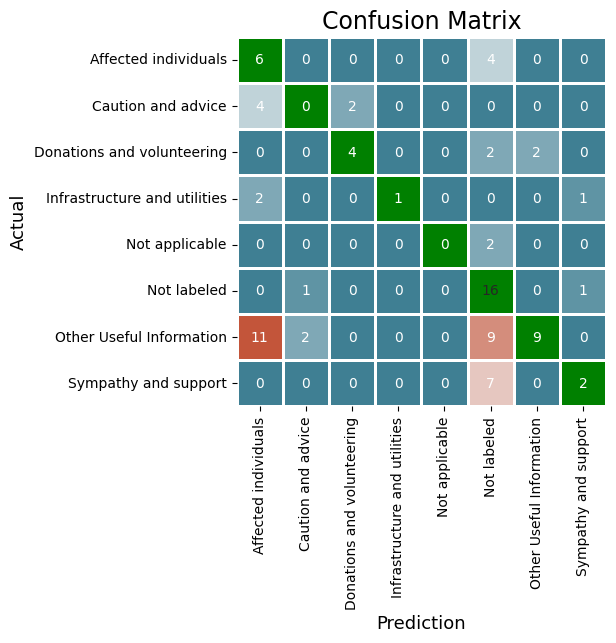

<Figure size 640x480 with 0 Axes>

In [ ]:
# # CM for Crisis Type
# plt_confusion_matrix(testing_df2['type'],testing_df2['parsed_pred_crisis_type_13'])

In [ ]:
# # Extract the actual and predicted values
# actual_values = testing_df['country_code']
# predicted_values = testing_df['Parsed_country_pred']

# # Calculate accuracy
# accuracy = accuracy_score(actual_values, predicted_values)

# # Calculate precision
# precision = precision_score(actual_values, predicted_values, average='weighted')

# # Calculate recall
# recall = recall_score(actual_values, predicted_values, average='weighted')

# # Calculate F1-score
# f1 = f1_score(actual_values, predicted_values, average='weighted')

# print(f'Accuracy: {accuracy}')
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')
# print(f'F1-score: {f1}')

[[ 7  1  0  0  0  1  1  0]
 [ 3  3  0  0  0  0  0  0]
 [ 3  1  2  0  0  2  0  0]
 [ 4  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  1  0  0]
 [ 0  2  0  0  0 11  5  0]
 [18  2  0  0  0  4  7  0]
 [ 0  1  0  0  0  5  0  3]]


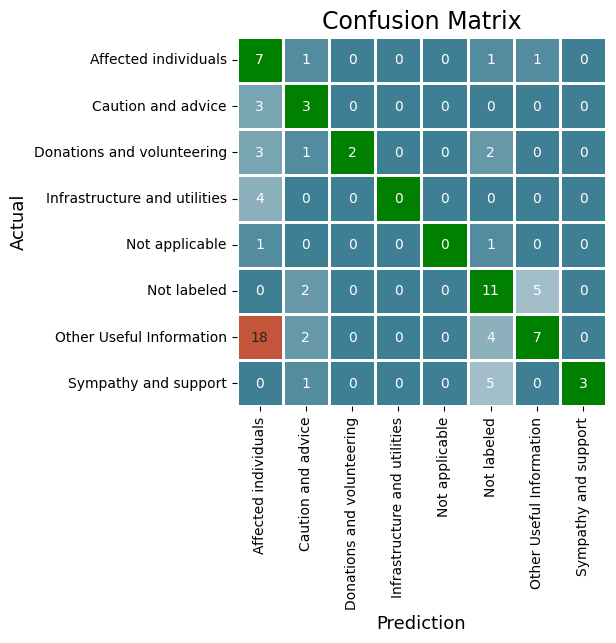

<Figure size 640x480 with 0 Axes>

In [ ]:
# # CM for Information Type v9

# plt_confusion_matrix(testing_df2['InformationType'],testing_df2['Parsed_Pred_InformationType_Baseline'])

[[ 6  0  0  0  0  4  0  0]
 [ 4  0  2  0  0  0  0  0]
 [ 0  0  4  0  0  2  2  0]
 [ 2  0  0  1  0  0  0  1]
 [ 0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0 16  0  1]
 [11  2  0  0  0  9  9  0]
 [ 0  0  0  0  0  7  0  2]]


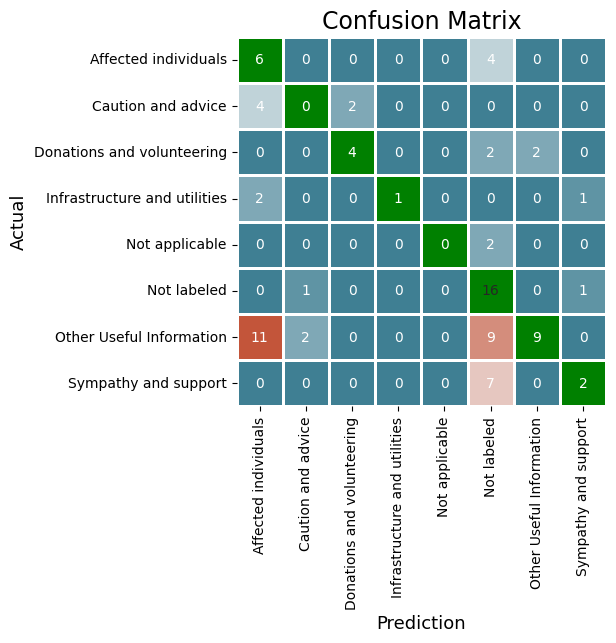

<Figure size 640x480 with 0 Axes>

In [ ]:
# # CM for Information Type Basline
# plt_confusion_matrix(testing_df2['InformationType'],testing_df2['Parsed_Pred_InformationType_v9'])

[[ 0  0  1  0]
 [ 0  0  5  1]
 [ 0  0 45 14]
 [ 0  0 15 10]]


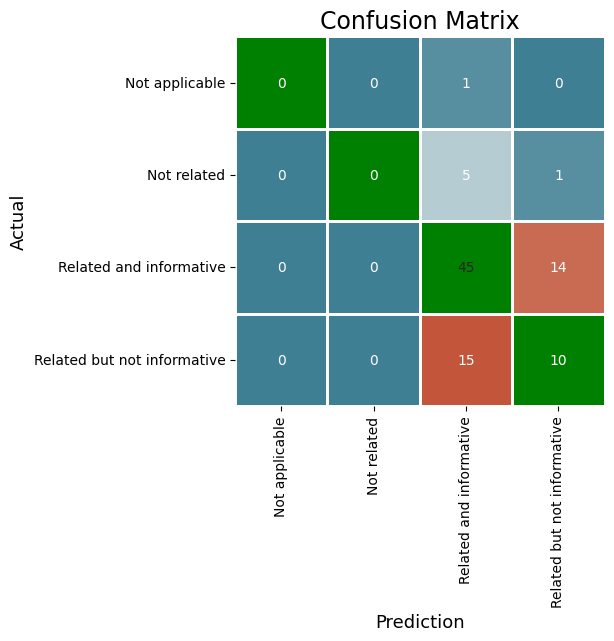

Accuracy: 0.6043956043956044
Precision: 0.551948051948052
Recall: 0.6043956043956044
F1-score: 0.5767032967032966


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

In [ ]:
# # CM for Informativeness
# plt_confusion_matrix(testing_df['Informativeness'],testing_df['Parsed_Informativeness_pred'])

# # Extract the actual and predicted values
# actual_values = testing_df['Informativeness']
# predicted_values = testing_df['Parsed_Informativeness_pred']

# # Calculate accuracy
# accuracy = accuracy_score(actual_values, predicted_values)

# # Calculate precision
# precision = precision_score(actual_values, predicted_values, average='weighted')

# # Calculate recall
# recall = recall_score(actual_values, predicted_values, average='weighted')

# # Calculate F1-score
# f1 = f1_score(actual_values, predicted_values, average='weighted')

# print(f'Accuracy: {accuracy}')
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')
# print(f'F1-score: {f1}')


[[ 5  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  1  0  0  0  1]
 [ 0  0  0  1  0  0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  4  0  0  9  0  0]
 [ 0  0  0  2  0 14  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  4]]


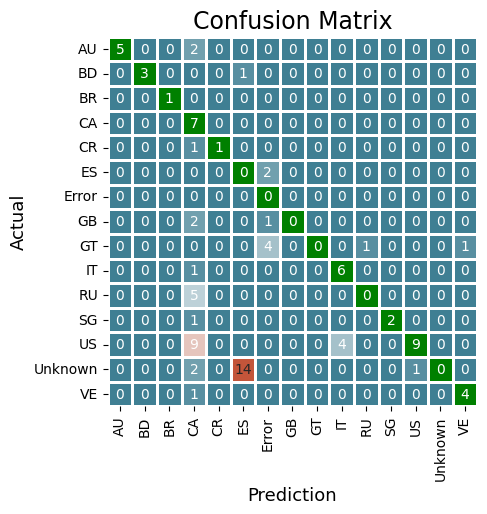

Accuracy: 0.4175824175824176
Precision: 0.5118752215526409
Recall: 0.4175824175824176
F1-score: 0.41637760367304816


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

In [ ]:
# # CM for Informativeness
# plt_confusion_matrix(testing_df['country_code'],testing_df['Parsed_country_pred'])

# # Extract the actual and predicted values
# actual_values = testing_df['country_code']
# predicted_values = testing_df['Parsed_country_pred']

# # Calculate accuracy
# accuracy = accuracy_score(actual_values, predicted_values)

# # Calculate precision
# precision = precision_score(actual_values, predicted_values, average='weighted')

# # Calculate recall
# recall = recall_score(actual_values, predicted_values, average='weighted')

# # Calculate F1-score
# f1 = f1_score(actual_values, predicted_values, average='weighted')

# print(f'Accuracy: {accuracy}')
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')
# print(f'F1-score: {f1}')


In [ ]:
# # Just a test to view unique values
# print(list(np.unique(predicted)))
# print(list(np.unique(actual)))
# # Number of rows in dataframe
# len(testing_df2.index)

['Affected individuals', 'Caution and advice', 'Donations and volunteering', 'Infrastructure and utilities', 'Not labeled', 'Other Useful Information', 'Sympathy and support']
['Affected individuals', 'Caution and advice', 'Donations and volunteering', 'Infrastructure and utilities', 'Not applicable', 'Not labeled', 'Other Useful Information', 'Sympathy and support']


88

In [ ]:
# len(testing_df2.index)

88

# Test

In [ ]:

# # Specify the file path for the CSV file you want to read
# file_path = '/content/gdrive/MyDrive/iLab2/results-CrisisType6.csv

# # Read the CSV file into a DataFrame
# df = pd.read_csv(file_path)



In [ ]:
# df['country'].unique()

array(['Canada', nan, 'Alberta', 'UK', 'Costa Rica', 'Phillipines', 'US',
       'Singapore', 'Russia', 'Chelyabinsk', 'Brazil', 'Bangladesh',
       'Philipinnes', 'Venezuela', 'Italy', 'Spain', 'Australia',
       'Guatemala', 'Sardinia'], dtype=object)

In [ ]:
# testing_df['country_code'].unique()

array(['VE', 'Unknown', 'AU', 'BD', 'IT', 'GB', 'US', 'RU', 'GT', 'CA',
       'CR', 'ES', 'BR', 'SG'], dtype=object)